<h1><center style="color:white;background:blue;border-radius:0px 25px;padding:25px">Zomato data</center></h1>
<h3><center>- Zomato is an Indian multinational restaurant aggregator and food delivery company founded by <span style="color:blue;">Deepinder Goyal</span> and <span style="color:blue;">Pankaj Chaddah</span> in <span style="color:blue;">2008</span>.</center></h3>
<h3><center>- Our data contain details about restaurants in <span style="color:blue;">Bangalore</span> city like (name, location, online_order, cuisines, ...etc).</center></h3>
<h3><center>- Our case is to see if new restaurant will open in this city will <span style="color:blue;">success or not</span>.</center></h3>
<ol>
    <li><a href="#readdata">Read data</a></li>
    <li><a href="#prep">data Preparation</a></li>
    <li><a href="#clean">data cleaning</a></li>
    <li><a href="#eda">EDA</a></li>
    <li><a href="#scrap">Data Scraping</a></li>
    <li><a href="#dataprep">Data Preprocessing</a></li>
    <li><a href="#model">Machine Learning Model</a></li>
    <li><a href="#tune">Hyperparameter tuning</a></li>
</ol>

## Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

import re
import time
# from selenium import webdriver
# from bs4 import BeautifulSoup

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score ,precision_score

import joblib
import json

import warnings
warnings.filterwarnings('ignore')

In [12]:
# !conda install -y gdown

In [13]:
# !gdown --id 1n6a_99NSyyM_UE7sCUp-1uijqcMbGWf-

<h1><center id="readdata" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Read data</center></h1>

In [14]:
df = pd.read_csv('./zomato.csv')
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

- There are missing values

<h1><center id="prep" style="color:white;background:blue;border-radius:25px 0px;padding:25px">data Preparation</center></h1>

## url (check url protocol)
- Some people are afraid from http protocol

In [16]:
df['url'].str.split(':').apply(lambda x: x[0]).value_counts()

https    51717
Name: url, dtype: int64

- This feature is useless

## Address
- Try to check if there is any info can be found in.

In [17]:
for i in np.random.choice(range(len(df)), 5, replace=False):
    print('adress=>', df.iloc[i]['address'])
    print('location=>', df.iloc[i]['location'])
    print('city=>', df.iloc[i]['listed_in(city)'])
    print('-'*30)

adress=> 1/2, Anjaneya Complex, Old Airport Road, Bangalore
location=> Old Airport Road
city=> Old Airport Road
------------------------------
adress=> No 6, Wood Street (Off Brigade Road), Ashok Nagar, Bangalore
location=> Brigade Road
city=> Frazer Town
------------------------------
adress=> 17/1 Cambridge Road, Opposite The Frank Antony School, Ulsoor, Bangalore
location=> Ulsoor
city=> Indiranagar
------------------------------
adress=> TRR Complex, Ramappa Layout, Tavarekere Bus Stop, Stage 1, BTM, Bangalore
location=> BTM
city=> BTM
------------------------------
adress=> 2nd Floor, 1 MG Mall, Trinity Circle, MG Road, Bangalore
location=> MG Road
city=> Brigade Road
------------------------------


- drop address later

## Rest Type

In [18]:
df['rest_type'].value_counts()

Quick Bites                   19132
Casual Dining                 10330
Cafe                           3732
Delivery                       2604
Dessert Parlor                 2263
                              ...  
Dessert Parlor, Kiosk             2
Food Court, Beverage Shop         2
Dessert Parlor, Food Court        2
Sweet Shop, Dessert Parlor        1
Quick Bites, Kiosk                1
Name: rest_type, Length: 93, dtype: int64

## Dish Liked

In [19]:
df['dish_liked'].value_counts()

Biryani                                                                                              182
Chicken Biryani                                                                                       73
Friendly Staff                                                                                        69
Waffles                                                                                               68
Paratha                                                                                               57
                                                                                                    ... 
Butter Chicken, Shawarma Roll, Chicken Shawarama, Chicken Grill, Rolls, Al Faham Chicken, Biryani      1
Filter Coffee, Sandwich, Bonda, Vada, Masala Dosa, Salad, Aloo Curry                                   1
Burgers, Fries, Jumbo Royale Burger, Salads, Peri Peri Chicken Salad, Potato Wedges, Rolls             1
Chaat, Pav Bhaji, Raj Kachori, Buttermilk, Ajwaini Para

## Cuisines

In [20]:
df['cuisines'].value_counts()

North Indian                                   2913
North Indian, Chinese                          2385
South Indian                                   1828
Biryani                                         918
Bakery, Desserts                                911
                                               ... 
North Indian, Chinese, South Indian, Juices       1
North Indian, Chinese, Kebab, Mughlai             1
Chinese, Vietnamese, Thai, Malaysian              1
Arabian, Lebanese, Chinese, Rolls                 1
North Indian, Chinese, Arabian, Momos             1
Name: cuisines, Length: 2723, dtype: int64

- In data preparation we will split each unique type as new feature in these 3 columns

## Approx Cost(for two people)

In [21]:
df['approx_cost(for two people)'].value_counts()

300      7576
400      6562
500      4980
200      4857
600      3714
         ... 
60          1
5,000       1
3,700       1
469         1
160         1
Name: approx_cost(for two people), Length: 70, dtype: int64

- This column must be int not object

In [22]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',', '')

In [23]:
df['approx_cost(for two people)'].isna().sum()

346

In [24]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

## menu_item

In [25]:
df['menu_item'].value_counts()[0] / len(df) *100

76.60343794110254

- 76% of data are missing

### let's drop useless columns
- listed_in(city) useless because there is a location for same value
- leave name and location now because we will use it in scraping

In [26]:
df.drop(['url', 'address', 'votes', 'phone', 'reviews_list', 'dish_liked', 'menu_item'], axis=1, inplace=True)

<h1><center id="clean" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Data Cleaning</center></h1>

## Missing values

In [27]:
df.isna().sum() / len(df) * 100

name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
location                        0.040606
rest_type                       0.438927
cuisines                        0.087012
approx_cost(for two people)     0.669026
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

### drop null values

In [28]:
df.dropna(subset=['rate', 'location', 'rest_type', 'cuisines', 'approx_cost(for two people)'], axis=0, inplace=True)

In [29]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

### Function belwo to split rate and take float value and convrt - to NEW

In [30]:
def change_rate(x):
    try:
        return float(x.split('/')[0])
    except:
        if x == '-':
            return 'NEW'
        else:
            return x

In [31]:
df['rate'] = df['rate'].apply(change_rate)

In [32]:
df['rate'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4.0, 4.2, 3.9, 3.1, 3.0, 3.2, 3.3, 2.8,
       4.4, 4.3, 'NEW', 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2.0, 1.8], dtype=object)

## Separate new restaurants from data
- Note: take only listed type == 'Delivery' and 'Dine-out'

<img src='images/Rate.jpg' height=350 width=700>

In [33]:
new_restaurants = df[(df['rate'] == 'NEW')&((df['listed_in(type)'] == 'Delivery') | (df['listed_in(type)'] == 'Dine-out'))]

In [34]:
# reset index
new_restaurants.reset_index(inplace=True)
new_restaurants.drop('index', axis=1, inplace=True)

### drop all NEW rate from data

In [35]:
new_index = df[df['rate'] == 'NEW'].index
df.drop(axis=0, index=new_index, inplace=True)

In [36]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41263 entries, 0 to 41262
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         41263 non-null  object
 1   online_order                 41263 non-null  object
 2   book_table                   41263 non-null  object
 3   rate                         41263 non-null  object
 4   location                     41263 non-null  object
 5   rest_type                    41263 non-null  object
 6   cuisines                     41263 non-null  object
 7   approx_cost(for two people)  41263 non-null  object
 8   listed_in(type)              41263 non-null  object
 9   listed_in(city)              41263 non-null  object
dtypes: object(10)
memory usage: 3.1+ MB


In [38]:
df['approx_cost(for two people)'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1200', '350', '250',
       '950', '1000', '1500', '1300', '199', '1100', '1600', '230', '130',
       '1700', '1350', '2200', '1400', '2000', '1800', '1900', '180',
       '330', '2500', '2100', '3000', '2800', '3400', '50', '40', '1250',
       '3500', '4000', '2400', '2600', '1450', '70', '3200', '240',
       '6000', '1050', '2300', '4100', '120', '5000', '3700', '1650',
       '2700', '4500', '80'], dtype=object)

In [39]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype('int')

## Outliers

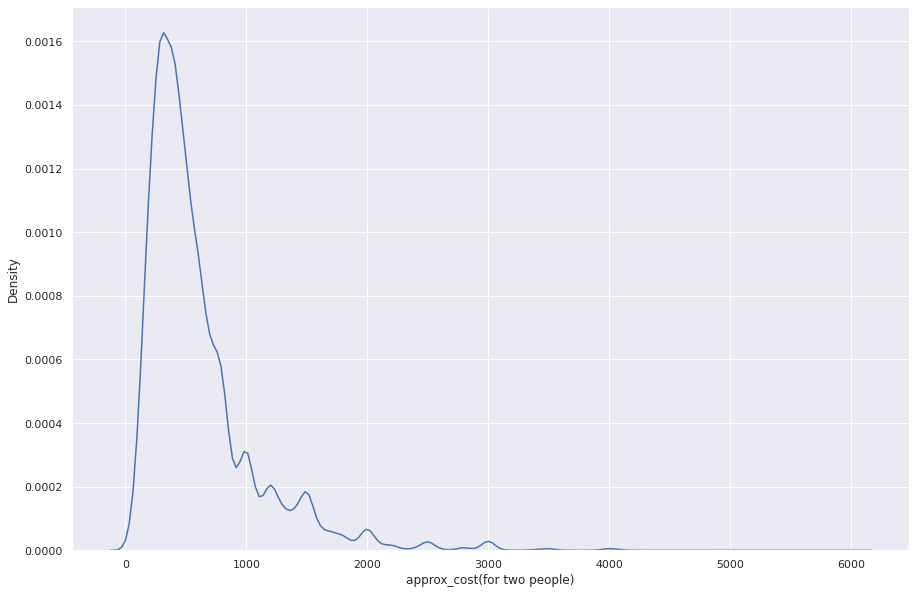

In [40]:
sns.kdeplot(x='approx_cost(for two people)', data=df);

- positively skewed
- I decided to remove the numbers greater than 2000

In [41]:
indecs = df[df['approx_cost(for two people)'] > 2000].index
df.drop(axis=0, index=list(indecs), inplace=True)

In [42]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

## Extract new column from rate called successful with value 1 if rate > 3.5 otherwise 0

In [43]:
df['successful'] = df['rate'].apply(lambda x: 'Yes' if x >= 3.5 else 'No')

In [44]:
df['successful'].value_counts()

Yes    29333
No     11313
Name: successful, dtype: int64

## Check duplicate values

In [45]:
duplicated = df[df.duplicated(keep='first', subset=list(df.columns))]
len(duplicated)

78

In [46]:
df.drop_duplicates(subset=list(df.columns), inplace=True)

In [47]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

- now drop name

In [48]:
df.drop('name', axis=1, inplace=True)

<h1><center id="eda" style="color:white;background:blue;border-radius:25px 0px;padding:25px">EDA</center></h1>

In [49]:
# Pie chart
def Pie(feature,Limit=20):
    global df
    fig, ax = plt.subplots(figsize=(10,6))
    plt.pie(df[feature].value_counts()[:Limit],labels=list(
        df[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(df[feature].value_counts()[:Limit]))])
    plt.show()
    
# Selected Pie      
def SelectedPie(feature,col, title1, title2, Limit=10):
    global df
    fig, ax = plt.subplots(figsize=(15,4))
    
    plt.subplot(1,2,1)
    plt.title(title1)
    Data = df[df[col]=='Yes']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
    
    plt.subplot(1,2,2)
    plt.title(title2)
    Data = df[df[col]=='No']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
    plt.show()

## Univariate Analysis

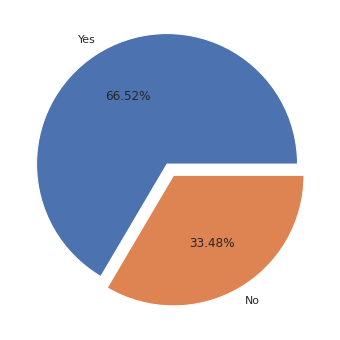

In [50]:
Pie('online_order')

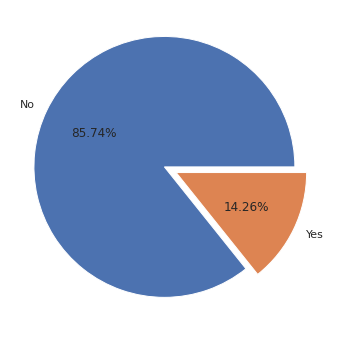

In [51]:
Pie('book_table')

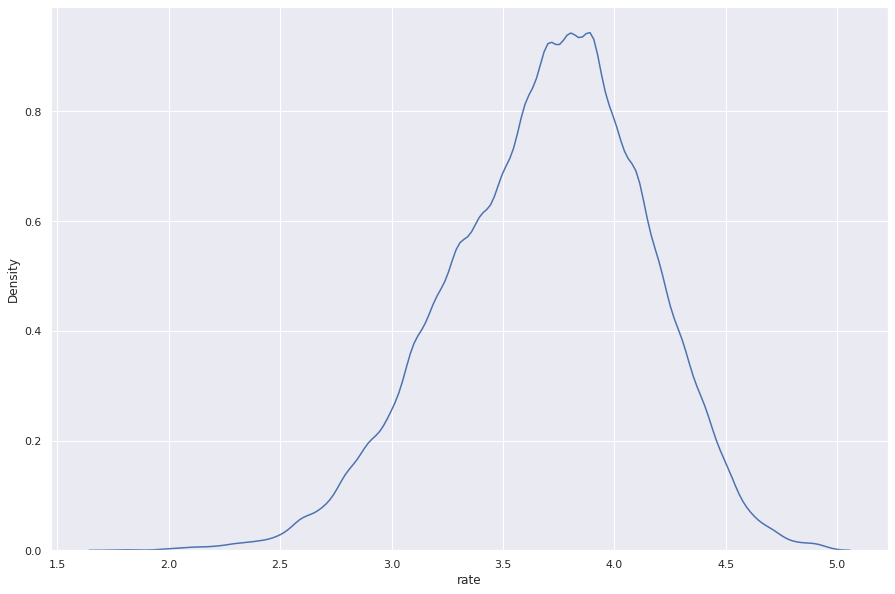

In [52]:
sns.kdeplot(x='rate', data=df);

### Function belwo to extract each type in each row to get unique

In [53]:
def unique_category(df, col):
    rest_type_list = []
    for row in df[col].str.split(','):
        for rest_type in row:
            rest_type_list.append(rest_type.strip().lower())
    return pd.Series(rest_type_list)

In [54]:
all_rest_type = unique_category(df, 'rest_type')

In [55]:
print("unique rest type in data:",len(df['rest_type'].unique()))
print("actual unique rest type in data:", len(all_rest_type.unique()))

unique rest type in data: 84
actual unique rest type in data: 24


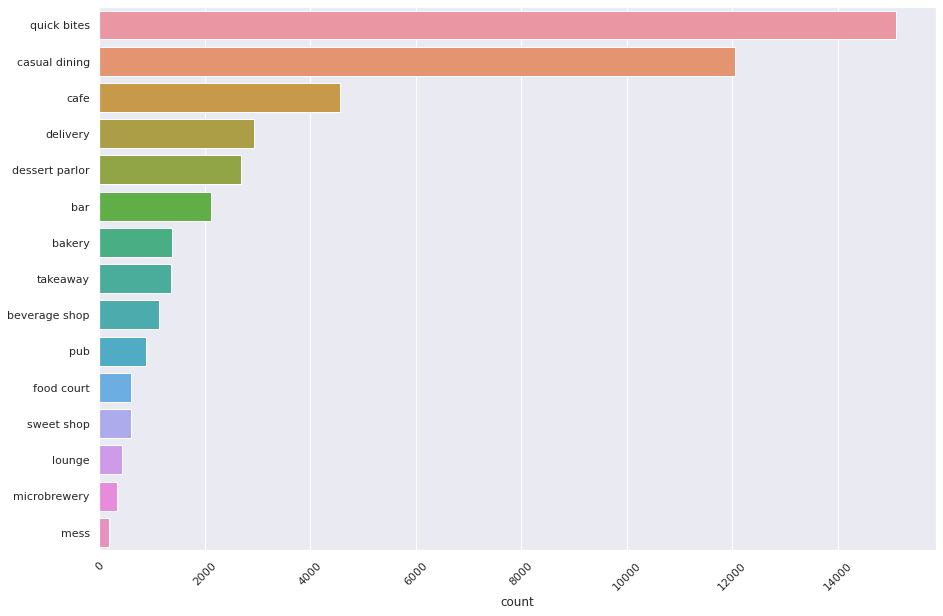

In [56]:
plt.figure(figsize=(15, 10))
sns.countplot(y=all_rest_type, order=all_rest_type.value_counts().iloc[:15].index)
plt.xticks(rotation=45)
plt.show();

In [57]:
all_cuisines = unique_category(df, 'cuisines')

In [58]:
print("unique cuisines in data:",len(df['cuisines'].unique()))
print("actual unique cuisines in data:", len(all_cuisines.unique()))

unique cuisines in data: 2318
actual unique cuisines in data: 104


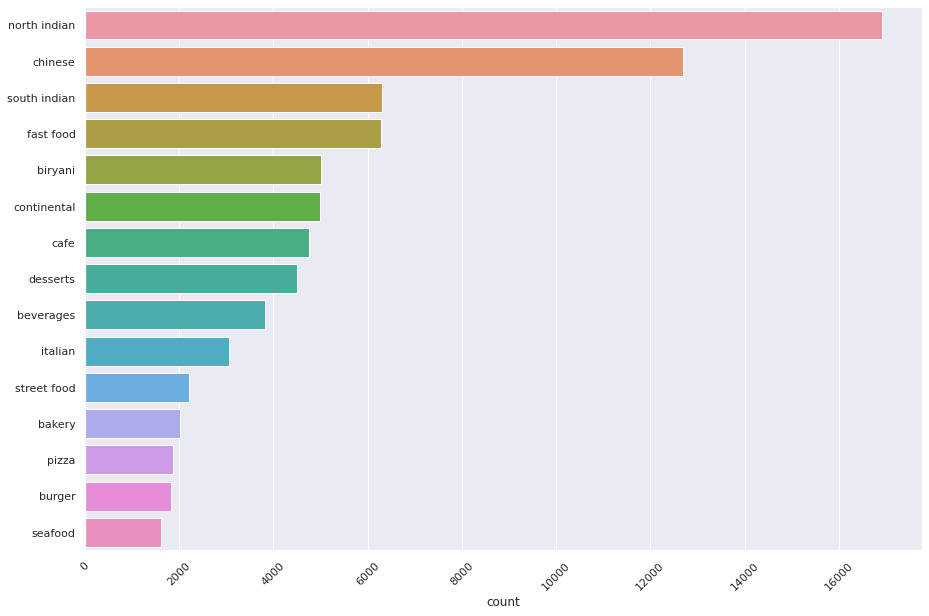

In [59]:
plt.figure(figsize=(15, 10))
sns.countplot(y=all_cuisines, order=all_cuisines.value_counts().iloc[:15].index)
plt.xticks(rotation=45)
plt.show();

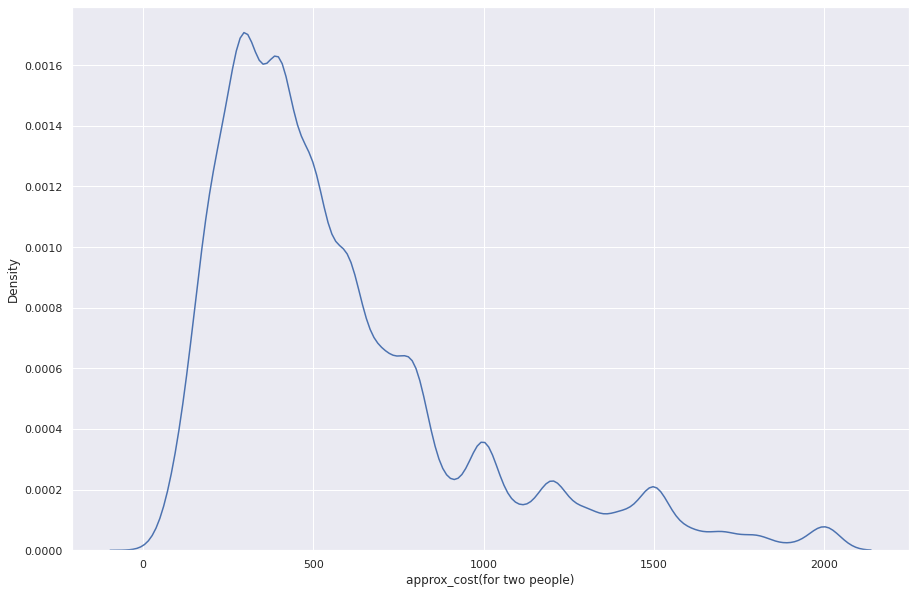

In [60]:
sns.kdeplot(x='approx_cost(for two people)', data=df);

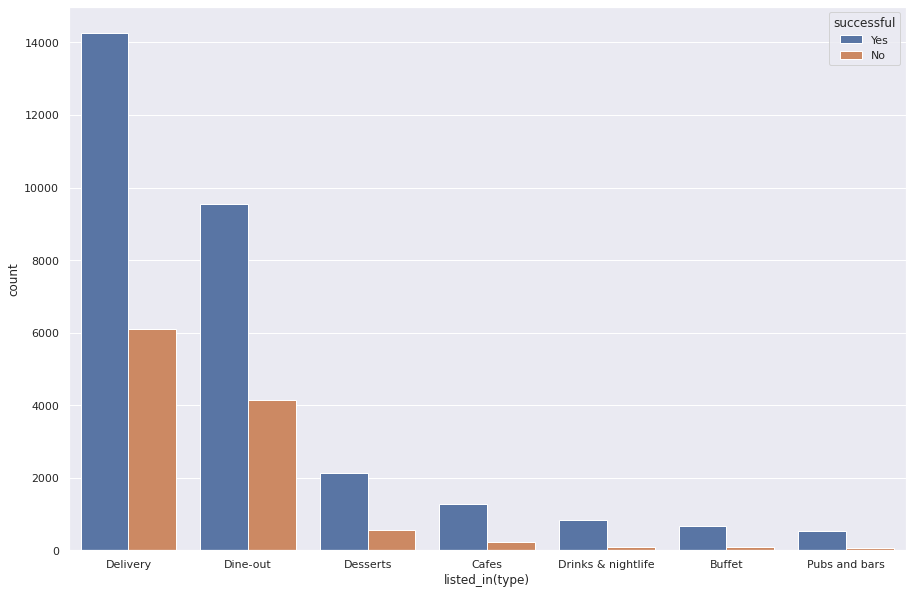

In [61]:
plt.figure(figsize=(15, 10))
sns.countplot(x='listed_in(type)', hue='successful', data=df, order=df['listed_in(type)'].value_counts().index);

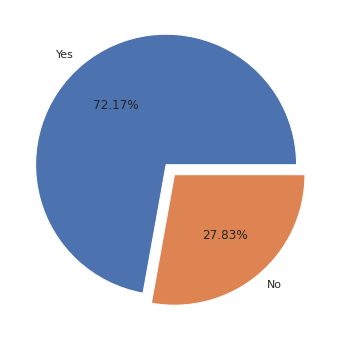

In [62]:
Pie('successful')

## multivariate Analysis

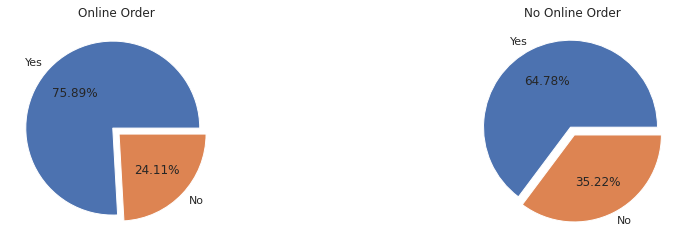

In [63]:
SelectedPie('successful', 'online_order', 'Online Order', 'No Online Order')

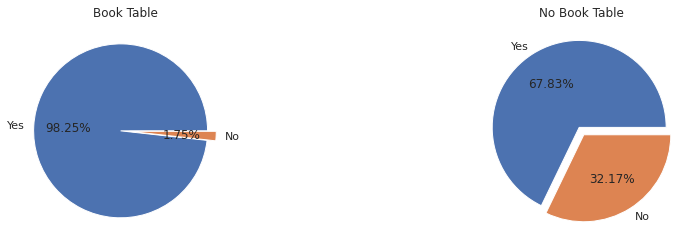

In [64]:
SelectedPie('successful', 'book_table', 'Book Table', 'No Book Table')

<h1><center id="scrap" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Data Scraping</center></h1>

## In this section we will scrap new restaurants data from the website

### take copy of data for some process

In [ ]:
new_res = new_restaurants.copy()

## Process the data to use it in the scraping later
- Remove symbols character
- Make names in lower case
- Join names with - to use them in url

In [ ]:
new_res['name'] = new_res['name'].apply(lambda x : re.sub(r'[^\w]', ' ', x))
new_res['name'] = new_res['name'].apply(lambda x : x.lower())
new_res['name'] = new_res['name'].apply(lambda x : "-".join(x.split()))

- Make location name in lower case
- Join loction names with - to use them in url too

In [ ]:
new_res['location'] = new_res['location'].apply(lambda x : x.lower())
new_res['location'] = new_res['location'].apply(lambda x : "-".join(x.split()))

## For scraping

In [ ]:
start = time.time()

headers = {
    'authority': 'scrapeme.live',
    'dnt': '1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,/;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'sec-fetch-site': 'none',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-user': '?1',
    'sec-fetch-dest': 'document',
    'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
}

driver = webdriver.Chrome(
    executable_path=r"chromedriver_win32\chromedriver.exe")

## scrap each restaurant separately

<img src='images/Address.jpg' height=350 width=700>

In [ ]:
for i in range(len(new_res)):
    url = f'https://www.zomato.com/bangalore/{new_res["name"].iloc[i]}-{new_res["location"].iloc[i]}-bangalore'
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to (open depends on you)
    # creating soup
    soup = BeautifulSoup(driver.page_source, "html.parser")
    # get div that has rating
    rate_divs = soup.findAll('div', class_='sc-1q7bklc-5 kHxpSk')
    # get div that has address details
    address_divs = soup.findAll('p', class_='sc-1hez2tp-0 clKRrC')
    # There are some restaurant I can't reach them so, using try, except to handle this issue
    try:
        # print('Address => ', address_divs[0].text.split(', '))
        # print('Listed in => ', new_res['listed_in(city)'].iloc[i])
        if new_res['listed_in(city)'].iloc[i] in address_divs[0].text.split(', '):
            try:
                # print('2nd try')
                # Conditions to put rate in right row
                if new_res['listed_in(type)'].iloc[i] == 'Dine-out':
                    # print('Dine out = ', rate_divs[0].text.split('star')[0])
                    new_res['rate'].iloc[i] = rate_divs[0].text.split('star')[0]
                else:
                    # print('dilevary = ', rate_divs[1].text.split('star')[0])
                    new_res['rate'].iloc[i] = rate_divs[1].text.split('star')[0]
            except:
                # print('can"t find rate')
                new_res['rate'].iloc[i] = np.nan
        else:
            # print('Else')
            new_res['rate'].iloc[i] = np.nan
    except:
        # print('can"t find listead_in city')
        new_res['rate'].iloc[i] = np.nan

## Take data before process and put rate = rating

In [ ]:
new_res['rate'].unique()

In [ ]:
new_restaurants['rate'] = new_res['rate']

## drop rows with null values or contain '-'

In [ ]:
indices = list(new_restaurants[(new_restaurants['rate'].isna()) | (new_restaurants['rate'] == '-')].index)
new_restaurants.drop(axis=0, index=indices, inplace=True)

In [ ]:
new_restaurants['rate'] = new_restaurants['rate'].astype('float')

In [ ]:
# drop name
new_restaurants.drop('name', axis=1, inplace=True)

In [ ]:
new_restaurants.to_csv('production_data.csv', index=False)

<h1><center id="dataprep" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Data Preprocessing</center></h1>

- take also production data

In [67]:
production_data = pd.read_csv('../input/production-data/production_data.csv')

In [68]:
production_data.columns

Index(['online_order', 'book_table', 'rate', 'location', 'rest_type',
       'cuisines', 'approx_cost(for two people)', 'listed_in(type)',
       'listed_in(city)'],
      dtype='object')

In [69]:
production_data['successful'] = production_data['rate'].apply(lambda x: 1 if x >= 3.5 else 0)

In [70]:
production_data.drop('rate', axis=1, inplace=True)
df.drop('rate', axis=1, inplace=True)

### function to convert Yes, No to 1 and 0

In [71]:
def replace_to_1_0(df, cols):
    for col in cols:
        df[col].replace({'Yes':1, 'No':0}, inplace=True)
    return df

In [72]:
cols = ['online_order', 'book_table', 'successful']
df = replace_to_1_0(df, cols)
test_data = replace_to_1_0(production_data, cols[:2])

In [73]:
# check columns are the same in two data
len(df.columns.sort_values()) == len(production_data.columns.sort_values())

True

In [74]:
df.head()

,online_order,book_table,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city),successful
0,1,1,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari,1
1,1,0,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari,1
2,1,0,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari,1
3,0,0,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari,1
4,0,0,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari,1


In [75]:
production_data.head()

,online_order,book_table,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city),successful
0,0,0,Banashankari,"Takeaway, Delivery","Street Food, Fast Food",500,Delivery,Banashankari,1
1,0,0,Banashankari,"Takeaway, Delivery","Sandwich, Pizza, Beverages",200,Delivery,Banashankari,1
2,0,0,Banashankari,"Takeaway, Delivery","Biryani, Rolls, Chinese",200,Delivery,Banashankari,1
3,0,0,Banashankari,Quick Bites,North Indian,100,Delivery,Banashankari,1
4,0,0,Banashankari,Quick Bites,"Biryani, Fast Food",400,Delivery,Banashankari,1


### Take copy of data

In [102]:
new_df = df.copy()
new_production_data = production_data.copy()

## Dummpy
- Rest type, Listed in type and cuisines

### Functions below
### Process $:-$
    - to make each unique type in column and put one in its position
### convertNull $:-$
    - to convert all null in new columns to 0

In [103]:
def process(df, col, unique_cols):
    df[sorted(list(unique_cols))] = np.nan
    for i in range(len(df)):
        for type in df[col].iloc[i].split(','):
            df[type.lower().strip()].iloc[i] = 1
    return df

In [104]:
def convertNull(df, cols):
    for col in cols:
        df[col].replace(np.nan, 0, inplace=True)
    return df

### Rest type

In [105]:
rest_type_cols = unique_category(new_df, 'rest_type').unique()

In [106]:
# data
new_df = process(new_df, 'rest_type', rest_type_cols)
new_df = convertNull(new_df, rest_type_cols)

In [107]:
# production
new_production_data = process(new_production_data, 'rest_type', rest_type_cols)
new_production_data = convertNull(new_production_data, rest_type_cols)

### Listed in type

In [108]:
list_type_cols = unique_category(new_df, 'listed_in(type)').unique()

In [109]:
# data
new_df = process(new_df, 'listed_in(type)', list_type_cols)
new_df = convertNull(new_df, list_type_cols)

In [110]:
# production
new_production_data = process(new_production_data, 'listed_in(type)', list_type_cols)
new_production_data = convertNull(new_production_data, list_type_cols)

### cuisines

In [111]:
cuisines_type_cols = unique_category(new_df, 'cuisines').unique()

In [112]:
# data
new_df = process(new_df, 'cuisines', cuisines_type_cols)
new_df = convertNull(new_df, cuisines_type_cols)

In [113]:
# production
new_production_data = process(new_production_data, 'cuisines', cuisines_type_cols)
new_production_data = convertNull(new_production_data, cuisines_type_cols)

In [114]:
# drop rest_type, listed_in(type), cuisines, listed_in(city)
new_df.drop(['listed_in(type)','rest_type', 'cuisines', 'listed_in(city)'], axis=1, inplace=True)
new_production_data.drop(['listed_in(type)','rest_type', 'cuisines', 'listed_in(city)'], axis=1, inplace=True)

## Binary encoding
- Location

In [115]:
from category_encoders.binary import BinaryEncoder

In [124]:
location_encoder = BinaryEncoder()

In [127]:
encoder_df = location_encoder.fit_transform(new_df['location'])
new_df[encoder_df.columns] = encoder_df

In [130]:
encoder_prod_df = location_encoder.transform(new_production_data['location'])
new_production_data[encoder_prod_df.columns] = encoder_prod_df

In [133]:
len(new_df.columns) == len(new_production_data.columns)

True

In [145]:
new_df.drop('location', axis=1, inplace=True)
new_production_data.drop('location', axis=1, inplace=True)

## Split data

In [146]:
x = new_df.drop(['successful'], axis=1)
y = new_df['successful']

In [147]:
cols = list(x.isna().sum()[x.isna().sum() > 1].index)
x = convertNull(x, cols)

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [149]:
len(x_test)

4057

## Scale

In [150]:
scale = StandardScaler()

In [151]:
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

<h1><center id="model" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Model</center></h1>

### Our data need algorithm with tree based to get high performance
- let's check DecisionTree, RandomForest, and XGBoost

In [152]:
models = {
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(),
}

In [153]:
for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    print(f'Training Accuracy: {train_score}')
    y_pred = model.predict(x_test)
    test_score = accuracy_score(y_test, y_pred)
    print(f'Testing Accuracy: {test_score}')
    pre_score = precision_score(y_test, y_pred)
    print(f'Testing precision score: {pre_score}')
    f_score = f1_score(y_test, y_pred)
    print("Testing F1 score ", f_score)
    print('-'*30)

Training Model DT 
--------------
Training Accuracy: 0.9772123469639287
Testing Accuracy: 0.9415824500862706
Testing precision score: 0.9638055842812823
Testing F1 score  0.959341224909933
------------------------------
Training Model RF 
--------------
Training Accuracy: 0.9772123469639287
Testing Accuracy: 0.9309834853339907
Testing precision score: 0.9463924477410655
Testing F1 score  0.9524940617577197
------------------------------
Training Model XGB 
--------------
Training Accuracy: 0.8223001287283285
Testing Accuracy: 0.803549420754252
Testing precision score: 0.8185351270553064
Testing F1 score  0.8729475530049418
------------------------------


### Wow! awesome accuracy let's check the production data

- Try with the best model

In [154]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
print(f'Training Accuracy: {train_score}')
y_pred = model.predict(x_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Testing Accuracy: {test_score}')
pre_score = precision_score(y_test, y_pred)
print(f'Testing precision score: {pre_score}')
f_score = f1_score(y_test, y_pred)
print("Testing F1 score ", f_score)

Training Accuracy: 0.9772123469639287
Testing Accuracy: 0.9398570372196204
Testing precision score: 0.9621212121212122
Testing F1 score  0.958161865569273


## Split production data into x, y

In [155]:
x_product = new_production_data.drop(['successful'], axis=1)
y_product = new_production_data['successful']

## Scale 

In [156]:
x_product = scale.transform(x_product)

In [157]:
y_pred = model.predict(x_product)
test_score = accuracy_score(y_product, y_pred)
print(f'Production Accuracy: {test_score}')
pre_score = precision_score(y_product, y_pred)
print(f'Production precision score: {pre_score}')
f_score = f1_score(y_product, y_pred)
print("Production F1 score ", f_score)

Production Accuracy: 0.5726027397260274
Production precision score: 0.8451327433628318
Production F1 score  0.7100371747211897


# WHAT!!! production accuracy is 57%

- Try with the worest model

In [158]:
model = XGBClassifier()
model.fit(x_train, y_train)
train_score = model.score(x_train, y_train)
print(f'Training Accuracy: {train_score}')
y_pred = model.predict(x_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Testing Accuracy: {test_score}')
pre_score = precision_score(y_test, y_pred)
print(f'Testing precision score: {pre_score}')
f_score = f1_score(y_test, y_pred)
print("Testing F1 score ", f_score)

Training Accuracy: 0.8223001287283285
Testing Accuracy: 0.803549420754252
Testing precision score: 0.8185351270553064
Testing F1 score  0.8729475530049418


In [159]:
y_pred = model.predict(x_product)
test_score = accuracy_score(y_product, y_pred)
print(f'Production Accuracy: {test_score}')
pre_score = precision_score(y_product, y_pred)
print(f'Production precision score: {pre_score}')
f_score = f1_score(y_product, y_pred)
print("Production F1 score ", f_score)

Production Accuracy: 0.663013698630137
Production precision score: 0.8539325842696629
Production F1 score  0.7875647668393781


- We can notice the accuracy is better now

<h1><center id="tune" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Hyperparameter tuning</center></h1>

In [160]:
model = RandomForestClassifier()

In [167]:
params = {
    "n_estimators": [75, 100],
    "max_depth": [16, 18, 20],
    "random_state": [None, 42]
}

In [168]:
GRD_search = GridSearchCV(estimator=model,param_grid=params, scoring='f1', n_jobs=-1, cv=10)

In [169]:
GRD_search.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=22, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20], 'n_estimators': [75, 100],
                         'random_state': [None, 42]},
             scoring='f1')

In [170]:
print("Best parameters", GRD_search.best_params_)
print("Best Score", GRD_search.best_score_)
model = GRD_search.best_estimator_
model

Best parameters {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
Best Score 0.8998706545625259


RandomForestClassifier(max_depth=20, random_state=42)

In [185]:
model = RandomForestClassifier(n_estimators=75, max_depth=16).fit(x_train, y_train)

In [186]:
train_score = model.score(x_train, y_train)
print(f'Training Accuracy: {train_score}')
y_pred = model.predict(x_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Testing Accuracy: {test_score}')
pre_score = precision_score(y_test, y_pred)
print(f'Testing precision score: {pre_score}')
f_score = f1_score(y_test, y_pred)
print("Testing F1 score ", f_score)

Training Accuracy: 0.8119744734463586
Testing Accuracy: 0.7949223564210007
Testing precision score: 0.7857142857142857
Testing F1 score  0.873862947240752


In [187]:
y_pred = model.predict(x_product)
test_score = accuracy_score(y_product, y_pred)
print(f'Production Accuracy: {test_score}')
pre_score = precision_score(y_product, y_pred)
print(f'Production precision score: {pre_score}')
f_score = f1_score(y_product, y_pred)
print("Production F1 score ", f_score)

Production Accuracy: 0.7972602739726027
Production precision score: 0.8628048780487805
Production F1 score  0.8843750000000001


## Now this model can be used in production

# Save $:-$
    1. dummy columns
    2. Scaler
    3. Encoders
    4. Model

### The 3 cells below to delete duplicate types

In [ ]:
cuisines_types = sorted(list(cuisines_type_cols))
cuisines_types.remove('cafe')
cuisines_types.remove('bakery')

In [ ]:
rest_types = sorted(list(rest_type_cols))
rest_types.remove('delivery')

In [ ]:
listed_types = sorted(list(list_type_cols))
listed_types.remove('desserts')

In [188]:
# dummy columns
dummies = {
    "rest_type": rest_types,
    "listed_in(type)": listed_types,
    "cuisines": cuisines_types,
    "location": sorted(list(df['location'].unique()))
}
with open(r"dummies.json", "w") as outfile:
    json.dump(dummies, outfile)
# Scaler
joblib.dump(scale, r'./scale.h5')
# Encoder
joblib.dump(location_encoder, r'./location_encoder.h5')
# # Model
joblib.dump(model, r'./model.h5')

['./model.h5']